# Timing of different image matchers

In [3]:
import cv2 as cv
import torch
import kornia
import time
from torchvision import transforms
import matplotlib.pyplot as plt


def preprocess_image(image):
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    scaled_image = cv.resize(image, (round(540 * image.shape[1] / image.shape[0]), 540))
    ratio_scaled2image = (
        image.shape[1] / scaled_image.shape[1],
        image.shape[0] / scaled_image.shape[0],
    )
    transform = transforms.Compose([transforms.ToTensor()])
    scaled_image = transform(scaled_image)
    scaled_image = torch.unsqueeze(scaled_image, dim=0)
    return scaled_image, ratio_scaled2image


def timing_batches_loftr(number_processed_images):
    device = torch.device(f"cuda:{0}" if torch.cuda.is_available() else "cpu")
    image_matcher = kornia.feature.LoFTR(pretrained="outdoor").to(device)

    # load action frame and neon patch
    action_frame = cv.imread("/users/sof/action_frame.png")
    neon_frame = cv.imread("/users/sof/neon_frame.png")
    x_min, y_min = 431, 200
    x_max, y_max = 1431, 1200
    neon_patch = neon_frame[y_min:y_max, x_min:x_max, :]

    # preprocess image
    action_frame, _ = preprocess_image(action_frame)
    neon_patch, _ = preprocess_image(neon_patch)
    timings= dict.fromkeys([1, 2, 5, 10])
    print(f"Number of processed images: {number_processed_images}")
    for batch_size in timings.keys():
        src_tensor = torch.cat([neon_patch] * batch_size, axis=0)
        dst_tensor = torch.cat([action_frame] * batch_size, axis=0)
        input_dict = {"image0": src_tensor, "image1": dst_tensor}
        for k in input_dict.keys():
                input_dict[k] = input_dict[k].to(device)
        
        
        start = time.perf_counter()
        for i in range(number_processed_images // batch_size):

            in_t=time.perf_counter()
            with torch.no_grad():
                correspondences = image_matcher(input_dict)
            out_t=time.perf_counter()
            
            # for k in correspondences.keys():
            #     correspondences[k] = (
            #         correspondences[k].cpu().numpy()
            #     )  # if you want to know which keypoints belong to which image, you have to look at 'batch_indexes'
            torch.cuda.empty_cache()
            # print(f"Batch {batch_size} in {out_t-in_t} seconds")

        end = time.perf_counter()
        timings[batch_size] = end - start
        print(
            f"(Batch {batch_size},LOFTR called {i+1} times)Finished in {end-start} seconds"
        )
    return timings

In [6]:
0.8386690519982949+ 0.8521602040855214

1.6908292560838163

In [4]:
proc_im=dict.fromkeys([10,20,40,50])
for i in proc_im.keys():
    proc_im[i]=timing_batches_loftr(i)


Number of processed images: 10
Batch 1 in 0.17108958796598017 seconds
Batch 1 in 0.1845473040593788 seconds
Batch 1 in 0.1678506110329181 seconds
Batch 1 in 0.19142158201429993 seconds
Batch 1 in 0.17742178100161254 seconds
Batch 1 in 0.19170311896596104 seconds
Batch 1 in 0.1692313039675355 seconds
Batch 1 in 0.16263658099342138 seconds
Batch 1 in 0.18212519399821758 seconds
Batch 1 in 0.16696261800825596 seconds
(Batch 1,LOFTR called 10 times)Finished in 3.0411751540377736 seconds
Batch 2 in 0.30818528798408806 seconds
Batch 2 in 0.31729785806965083 seconds
Batch 2 in 0.32057373493444175 seconds
Batch 2 in 0.320265986956656 seconds
Batch 2 in 0.34389219305012375 seconds
(Batch 2,LOFTR called 5 times)Finished in 2.6679027639329433 seconds
Batch 5 in 0.8521602040855214 seconds
Batch 5 in 0.8386690519982949 seconds
(Batch 5,LOFTR called 2 times)Finished in 2.393574756104499 seconds
Batch 10 in 1.925593122956343 seconds
(Batch 10,LOFTR called 1 times)Finished in 2.6393503369763494 second

(2.0, 16.0)

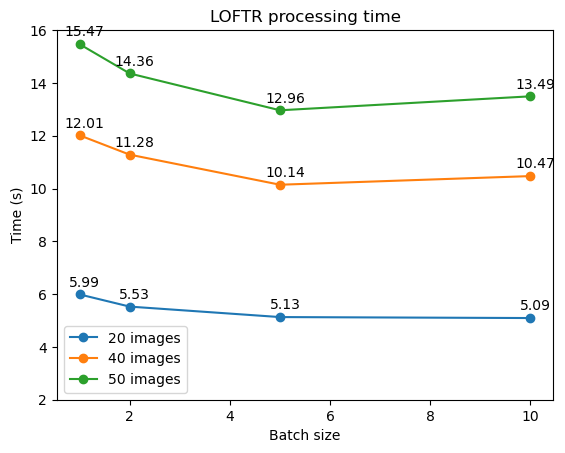

In [5]:
fig, ax = plt.subplots()
for i in proc_im.keys():
    if i==10:
        continue
    ax.plot(proc_im[i].keys(),proc_im[i].values(),'-o',label=f'{i} images')
    for x,y,z in zip(proc_im[i].keys(),proc_im[i].values(),proc_im[i].values()):
    #change f'{z:.2f}' to str(z) if you want something simpler
        ax.text(x+0.1,y+.3,f'{z:.2f}',horizontalalignment='center',color='k',weight='light')
ax.legend()
ax.set_xlabel('Batch size')
ax.set_ylabel('Time (s)')
ax.set_title('LOFTR processing time')
ax.set_ylim(2,16)

In [ ]:
def timing_batches_diskLG(number_processed_images):

    device = torch.device(f"cuda:{0}" if torch.cuda.is_available() else "cpu")
    feature_extractor = kornia.feature.DISK.from_pretrained("depth").to(device)
    feature_matcher = kornia.feature.LightGlue("disk").eval().to(device)
    # load action frame and neon patch
    action_frame = cv.imread("/users/sof/action_frame.png")
    neon_frame = cv.imread("/users/sof/neon_frame.png")
    x_min, y_min = 431, 200
    x_max, y_max = 1431, 1200
    neon_patch = neon_frame[y_min:y_max, x_min:x_max, :]

    # preprocess image
    action_frame, _ = preprocess_image(action_frame)
    neon_patch, _ = preprocess_image(neon_patch)
    timings= dict.fromkeys([1, 2, 5, 10])
    print(f"Number of processed images: {number_processed_images}")
    for batch_size in timings.keys():
        src_tensor = torch.cat([neon_patch] * batch_size, axis=0)
        dst_tensor = torch.cat([action_frame] * batch_size, axis=0)
        input_dict = {"image0": src_tensor, "image1": dst_tensor}
        for k in input_dict.keys():
                input_dict[k] = input_dict[k].to(device)
        start = time.perf_counter()

        for i in range(number_processed_images // batch_size):
            in_t=time.perf_counter()
            
            with torch.no_grad():
                correspondences = image_matcher(input_dict)

            out_t=time.perf_counter()
            
            for k in correspondences.keys():
                correspondences[k] = (
                    correspondences[k].cpu().numpy()
                )  # if you want to know which keypoints belong to which image, you have to look at 'batch_indexes'
            torch.cuda.empty_cache()
            
            print(f"Batch {batch_size} in {out_t-in_t} seconds")

        end = time.perf_counter()
        timings[batch_size] = end - start
        print(
            f"(Batch {batch_size},LOFTR called {i+1} times)Finished in {end-start} seconds"
        )
    return timings